In [ ]:
from pathlib import Path
import sys

# --- Notebook bootstrap (works from repo root or notebooks/) ---
REPO_ROOT = Path.cwd()
if not (REPO_ROOT / 'mm').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

DATA_ROOT = REPO_ROOT / 'data'
OUT_ROOT = REPO_ROOT / 'out'

print('REPO_ROOT:', REPO_ROOT)


# Latency analysis for recorder data (Binance WS)

This notebook computes **event → receive latency** for:
- **Depth diffs** (from `diffs/depth_diffs_*.ndjson.gz`)
- **Trades** (from `trades_ws_*.csv.gz`)

Latency is measured as:

$$\text{latency\_ms} = \text{recv\_ms} - E$$

Where:
- `E` is Binance event time (ms since epoch)
- `recv_ms` is when your recorder received and timestamped the message

This is a practical proxy for *end-to-end* latency (network + TLS + websocket client + Python dispatch + VM overhead).


In [12]:
from pathlib import Path
import gzip, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---- Configure these ----
# DATA_ROOT is provided by the bootstrap cell
SYMBOL = 'ETHUSDT'
DAY = '20251218'              # YYYYMMDD (folder name)

day_dir = DATA_ROOT / SYMBOL / DAY
day_dir


PosixPath('data/ETHUSDT/20251218')

In [26]:
match = day_dir.glob(f'diffs/depth_diffs_{SYMBOL}_{DAY}.ndjson.gz')


match

In [31]:
def find_one(glob_pat: str) -> Path:
    matches = sorted(day_dir.glob(glob_pat))
    if not matches:
        raise FileNotFoundError(f'No files matched {glob_pat} under {day_dir}')
    return matches[-1]

diff_path = find_one(f'diffs/depth_diffs_{SYMBOL}_{DAY}.ndjson.gz')
trades_path = find_one(f"trades_ws_{SYMBOL}_{DAY}.csv.gz")
print('diffs:', diff_path)
print('trades:', trades_path)


diffs: data/ETHUSDT/20251218/diffs/depth_diffs_ETHUSDT_20251218.ndjson.gz
trades: data/ETHUSDT/20251218/trades_ws_ETHUSDT_20251218.csv


In [32]:
# Load diffs (only fields needed for latency)
diff_rows = []
with gzip.open(diff_path, 'rt', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        obj = json.loads(line)
        diff_rows.append({
            'recv_ms': int(obj.get('recv_ms', 0)),
            'E': int(obj.get('E', 0)),
            'U': int(obj.get('U', 0)),
            'u': int(obj.get('u', 0)),
        })

df_diff = pd.DataFrame(diff_rows)
df_diff['latency_ms'] = df_diff['recv_ms'] - df_diff['E']
df_diff.head()


,recv_ms,E,U,u,latency_ms
0,1766041200138,1766041200115,67357125629,67357125653,23
1,1766041200218,1766041200215,67357125654,67357125660,3
2,1766041200317,1766041200315,67357125661,67357125666,2
3,1766041200417,1766041200415,67357125667,67357125697,2
4,1766041200518,1766041200515,67357125698,67357125733,3


In [33]:
# Load trades
df_tr = pd.read_csv(trades_path)
if 'recv_time_ms' not in df_tr.columns:
    df_tr['recv_time_ms'] = df_tr['event_time_ms']
df_tr['latency_ms'] = df_tr['recv_time_ms'] - df_tr['event_time_ms']
df_tr.head()


,event_time_ms,recv_time_ms,run_id,price,qty,is_buyer_maker,latency_ms
0,1766041200103,1766041200138,1766041200000,2831.35,0.0042,0,35
1,1766041200660,1766041200663,1766041200000,2831.35,0.0882,0,3
2,1766041201919,1766041201922,1766041200000,2831.35,0.0035,0,3
3,1766041201919,1766041201923,1766041200000,2831.35,0.0026,0,4
4,1766041201919,1766041201923,1766041200000,2831.35,0.0035,0,4


In [34]:
def summarize_latency(series: pd.Series) -> pd.DataFrame:
    s = series.dropna()
    return pd.DataFrame({
        'count': [int(s.shape[0])],
        'mean_ms': [float(s.mean())],
        'median_ms': [float(s.median())],
        'std_ms': [float(s.std())],
        'p90_ms': [float(s.quantile(0.90))],
        'p95_ms': [float(s.quantile(0.95))],
        'p99_ms': [float(s.quantile(0.99))],
        'min_ms': [float(s.min())],
        'max_ms': [float(s.max())],
    })

diff_lat = df_diff['latency_ms']
trade_lat = df_tr['latency_ms']

print('--- Depth diffs latency (raw) ---')
display(summarize_latency(diff_lat))
print('--- Trades latency (raw) ---')
display(summarize_latency(trade_lat))

# For conservative calibration, clip to >=0
diff_lat_clip = diff_lat.clip(lower=0)
trade_lat_clip = trade_lat.clip(lower=0)
print('--- Depth diffs latency (clipped >=0) ---')
display(summarize_latency(diff_lat_clip))
print('--- Trades latency (clipped >=0) ---')
display(summarize_latency(trade_lat_clip))


--- Depth diffs latency (raw) ---


,count,mean_ms,median_ms,std_ms,p90_ms,p95_ms,p99_ms,min_ms,max_ms
0,503916,3.329769,3.0,7.294285,5.0,7.0,11.0,1.0,977.0


--- Trades latency (raw) ---


,count,mean_ms,median_ms,std_ms,p90_ms,p95_ms,p99_ms,min_ms,max_ms
0,6270415,10.420863,6.0,17.076203,25.0,32.0,44.0,1.0,996.0


--- Depth diffs latency (clipped >=0) ---


,count,mean_ms,median_ms,std_ms,p90_ms,p95_ms,p99_ms,min_ms,max_ms
0,503916,3.329769,3.0,7.294285,5.0,7.0,11.0,1.0,977.0


--- Trades latency (clipped >=0) ---


,count,mean_ms,median_ms,std_ms,p90_ms,p95_ms,p99_ms,min_ms,max_ms
0,6270415,10.420863,6.0,17.076203,25.0,32.0,44.0,1.0,996.0


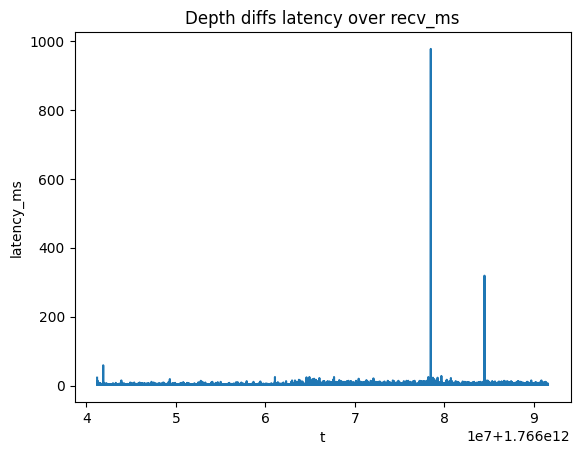

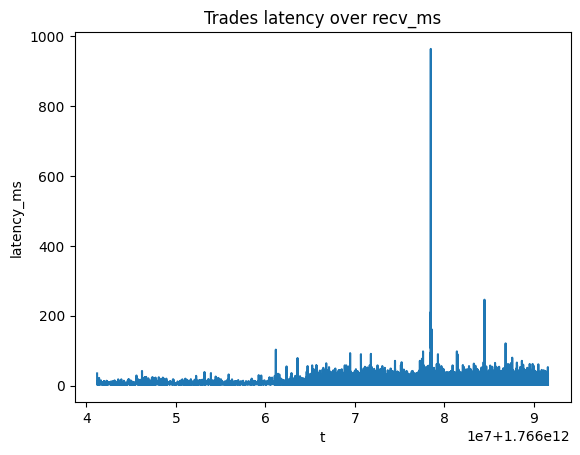

In [35]:
def plot_timeseries(df: pd.DataFrame, t_col: str, lat_col: str, title: str, max_points: int = 20_000):
    d = df[[t_col, lat_col]].dropna().copy().sort_values(t_col)
    if len(d) > max_points:
        d = d.iloc[::max(1, len(d)//max_points)]
    plt.figure()
    plt.plot(d[t_col].values, d[lat_col].values)
    plt.title(title)
    plt.xlabel(t_col)
    plt.ylabel('latency_ms')
    plt.show()

plot_timeseries(df_diff.rename(columns={'recv_ms':'t'}), 't', 'latency_ms', 'Depth diffs latency over recv_ms')
plot_timeseries(df_tr.rename(columns={'recv_time_ms':'t'}), 't', 'latency_ms', 'Trades latency over recv_ms')


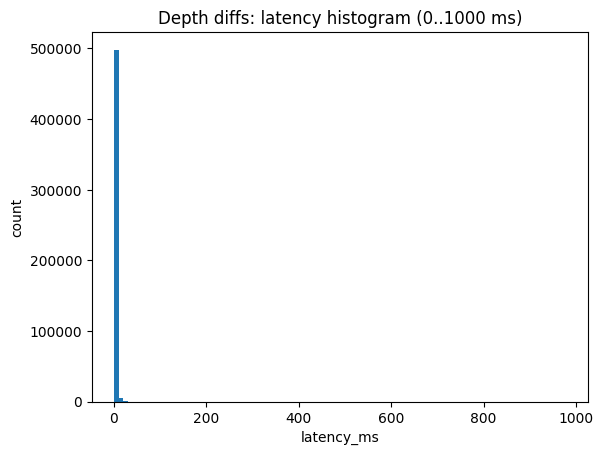

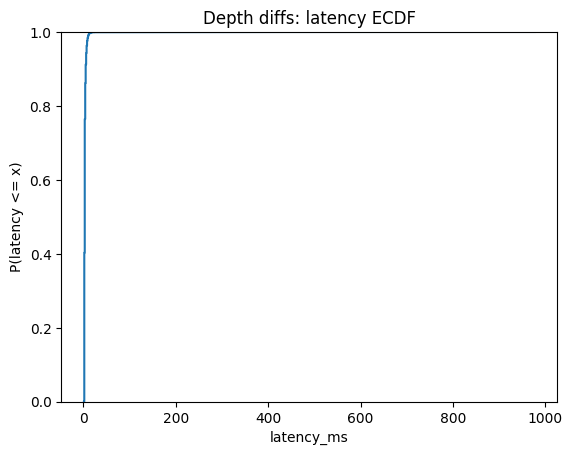

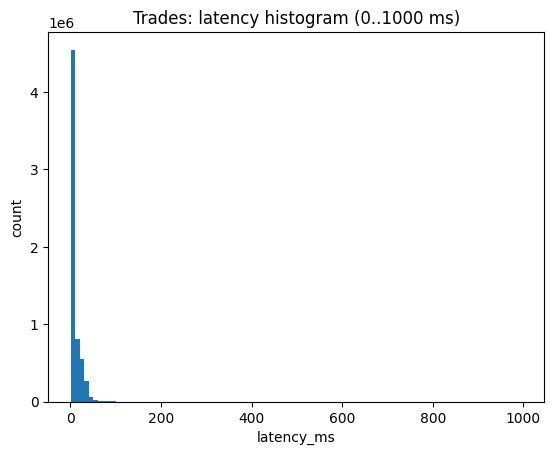

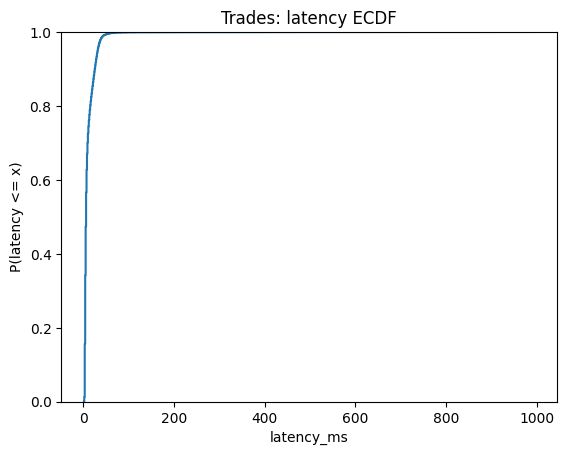

In [36]:
def plot_hist_ecdf(lat_ms: pd.Series, title_prefix: str, max_ms: int = 1000):
    s = lat_ms.dropna().clip(lower=0)
    s = s[s <= max_ms]
    plt.figure()
    plt.hist(s.values, bins=100)
    plt.title(f'{title_prefix}: latency histogram (0..{max_ms} ms)')
    plt.xlabel('latency_ms')
    plt.ylabel('count')
    plt.show()

    xs = np.sort(s.values)
    ys = np.arange(1, len(xs) + 1) / len(xs)
    plt.figure()
    plt.plot(xs, ys)
    plt.title(f'{title_prefix}: latency ECDF')
    plt.xlabel('latency_ms')
    plt.ylabel('P(latency <= x)')
    plt.ylim(0, 1)
    plt.show()

plot_hist_ecdf(diff_lat, 'Depth diffs')
plot_hist_ecdf(trade_lat, 'Trades')


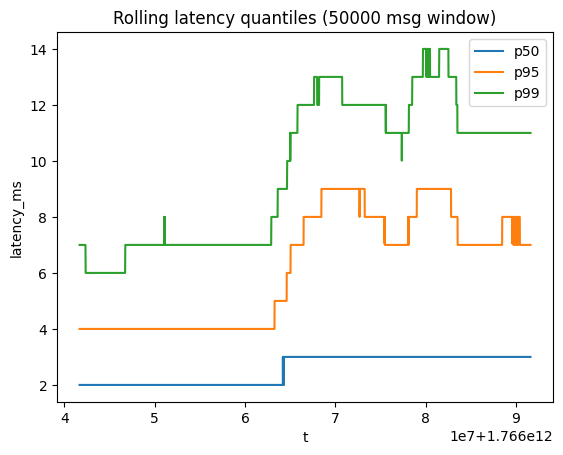

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


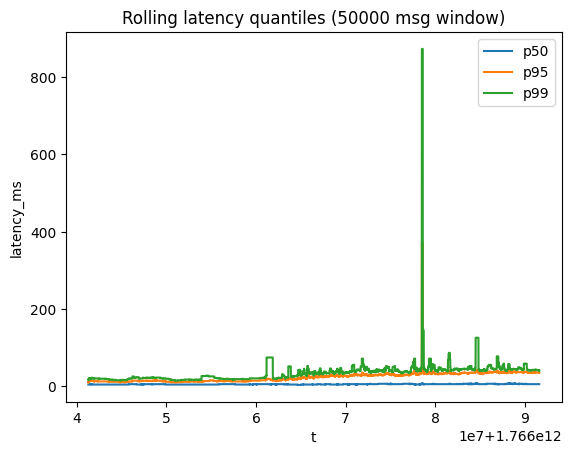

In [37]:
def rolling_quantiles(df: pd.DataFrame, t_col: str, lat_col: str, window: int = 50_000):
    d = df[[t_col, lat_col]].dropna().sort_values(t_col).copy()
    d[lat_col] = d[lat_col].clip(lower=0)
    r50 = d[lat_col].rolling(window, min_periods=max(10, window//10)).quantile(0.50)
    r95 = d[lat_col].rolling(window, min_periods=max(10, window//10)).quantile(0.95)
    r99 = d[lat_col].rolling(window, min_periods=max(10, window//10)).quantile(0.99)
    plt.figure()
    plt.plot(d[t_col].values, r50.values, label='p50')
    plt.plot(d[t_col].values, r95.values, label='p95')
    plt.plot(d[t_col].values, r99.values, label='p99')
    plt.title(f'Rolling latency quantiles ({window} msg window)')
    plt.xlabel(t_col)
    plt.ylabel('latency_ms')
    plt.legend()
    plt.show()

rolling_quantiles(df_diff.rename(columns={'recv_ms':'t'}), 't', 'latency_ms', window=50_000)
rolling_quantiles(df_tr.rename(columns={'recv_time_ms':'t'}), 't', 'latency_ms', window=50_000)


## Recommendation: picking `ORDER_LATENCY_MS`

A constant `ORDER_LATENCY_MS` is an approximation. A defensible choice is percentile-based:

- **Baseline**: `ORDER_LATENCY_MS = max(p95_depth, p95_trade)`
- **Conservative**: `ORDER_LATENCY_MS = max(p99_depth, p99_trade)`

Notes:
- If you see many negative latencies, ensure your machine/VM clock is synchronized (NTP).
- Later you can sample latency from the empirical distribution instead of using a constant.
- If you model **observation latency**, you should also apply it to the market state seen by your strategy.


In [38]:
p95_depth = float(diff_lat_clip.quantile(0.95))
p99_depth = float(diff_lat_clip.quantile(0.99))
p95_trade = float(trade_lat_clip.quantile(0.95))
p99_trade = float(trade_lat_clip.quantile(0.99))

rec_p95 = max(p95_depth, p95_trade)
rec_p99 = max(p99_depth, p99_trade)

print(f'p95 depth={p95_depth:.1f} ms, p95 trade={p95_trade:.1f} ms => recommend ORDER_LATENCY_MS≈{rec_p95:.0f} ms')
print(f'p99 depth={p99_depth:.1f} ms, p99 trade={p99_trade:.1f} ms => conservative ORDER_LATENCY_MS≈{rec_p99:.0f} ms')


p95 depth=7.0 ms, p95 trade=32.0 ms => recommend ORDER_LATENCY_MS≈32 ms
p99 depth=11.0 ms, p99 trade=44.0 ms => conservative ORDER_LATENCY_MS≈44 ms


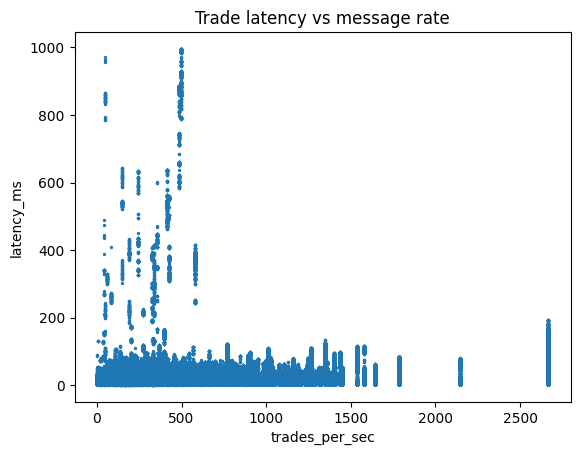

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(trades_path)
if 'recv_time_ms' not in df.columns:
    df['recv_time_ms'] = df['event_time_ms']

df['latency_ms'] = df['recv_time_ms'] - df['event_time_ms']

# trade rate per second (based on recv time)
df['sec'] = (df['recv_time_ms'] // 700).astype(int)
rate = df.groupby('sec').size().rename('trades_per_sec').reset_index()

# join back to each trade row
df = df.merge(rate, on='sec', how='left')

plt.figure()
plt.scatter(df['trades_per_sec'], df['latency_ms'], s=2)
plt.xlabel('trades_per_sec')
plt.ylabel('latency_ms')
plt.title('Trade latency vs message rate')
plt.show()


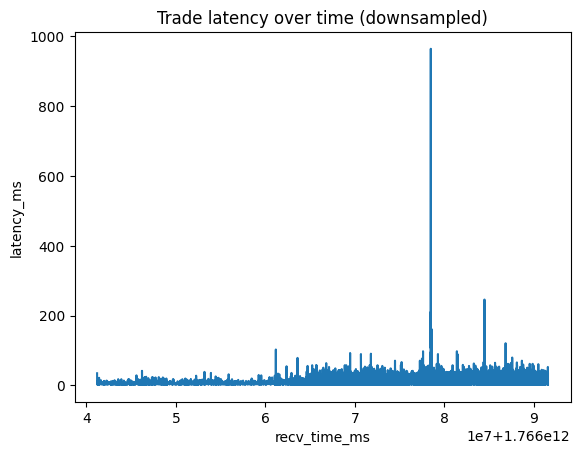

In [59]:
d = df[['recv_time_ms','latency_ms']].sort_values('recv_time_ms')
# downsample for plotting speed
d2 = d.iloc[::max(1, len(d)//20000)]

plt.figure()
plt.plot(d2['recv_time_ms'], d2['latency_ms'])
plt.xlabel('recv_time_ms')
plt.ylabel('latency_ms')
plt.title('Trade latency over time (downsampled)')
plt.show()


         recv_dt_ms   event_dt_ms
count  6.270414e+06  6.270414e+06
mean   8.037719e+00  8.037724e+00
std    8.517849e+01  8.532408e+01
min    0.000000e+00 -6.400000e+01
50%    0.000000e+00  0.000000e+00
90%    1.000000e+00  0.000000e+00
99%    1.960000e+02  1.980000e+02
max    9.479000e+03  9.479000e+03


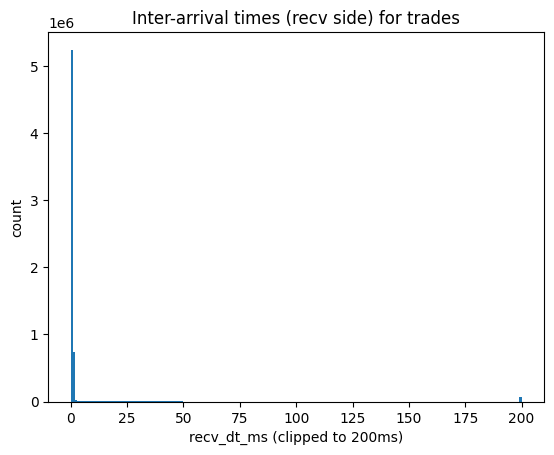

In [60]:
d = df.sort_values('recv_time_ms')
d['recv_dt_ms'] = d['recv_time_ms'].diff()
d['event_dt_ms'] = d['event_time_ms'].diff()

print(d[['recv_dt_ms','event_dt_ms']].describe(percentiles=[0.5,0.9,0.99]))

plt.figure()
plt.hist(d['recv_dt_ms'].dropna().clip(0, 200), bins=200)
plt.xlabel('recv_dt_ms (clipped to 200ms)')
plt.ylabel('count')
plt.title('Inter-arrival times (recv side) for trades')
plt.show()
